In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Map sensor locations to DataFrame columns
location_to_column = {
    "Left Knee": "leftKneeFlexionAngle",
    "Left Hip": "leftHipFlexionAngle",
    "Left Ankle": "leftAnkleAngle",
    "Right Knee": "rightKneeFlexionAngle",
    "Right Hip": "rightHipFlexionAngle",
    "Right Ankle": "rightAnkleAngle"
}

def process_json_data(json_data):
    angles = {"timestamp": json_data["timestamp"]}
    
    # Extract roll angles from each sensor
    for sensor in json_data["sensors"]:
        location = sensor["location"]
        if location in location_to_column:
            column_name = location_to_column[location]
            angles[column_name] = sensor["euler"]["roll"]
    
    columns_order = [
        'rightKneeFlexionAngle',
        'rightHipFlexionAngle', 
        'rightAnkleAngle',
        'leftKneeFlexionAngle', 
        'leftHipFlexionAngle', 
        'leftAnkleAngle'
    ]
    
    return angles

In [38]:
def process_json_data(json_data, gait_type):
    angles = {"timestamp": json_data["timestamp"], "gait_type": gait_type}
    
    # Extract roll angles from each sensor
    for sensor in json_data["sensors"]:
        location = sensor["location"]
        if location in location_to_column:
            column_name = location_to_column[location]
            angles[column_name] = sensor["euler"]["roll"]
    
    return angles

# Load and process both datasets with gait labels
def load_datasets():
    # Walking data
    walking_data = []
    DATA_DIR = 'walkingData'
    JSON_EXT = '.json'
    
    file_paths = [DATA_DIR+"/"+f for f in os.listdir(DATA_DIR) if f[-len(JSON_EXT):] == JSON_EXT]
    
    for fp in file_paths:
        with open(fp, 'r') as file:
            walking_data.append([json.loads(line.strip()) for line in file if line.strip()])
    
    walking_processed = []
    for dataset in walking_data:
        walking_processed.extend([process_json_data(entry, 0) for entry in dataset])  # 0 for walking
        
        
    # Stair climbing data
    stair_data = []
    DATA_DIR = 'stairData'
    file_paths = [DATA_DIR+"/"+f for f in os.listdir(DATA_DIR) if f[-len(JSON_EXT):] == JSON_EXT]
    
    for fp in file_paths:
        with open(fp, 'r') as file:
            stair_data.append([json.loads(line.strip()) for line in file if line.strip()])
    
    stair_processed = []
    for dataset in stair_data:
        stair_processed.extend([process_json_data(entry, 1) for entry in dataset])  # 1 for stair climbing
    
    return walking_processed, stair_processed


walking_data, stair_data = load_datasets()

# Combine datasets
all_data = walking_data + stair_data

# Convert to DataFrame
combined_df = pd.DataFrame(all_data)


combined_df["timestamp"] = pd.to_datetime(combined_df["timestamp"])
combined_df = combined_df.set_index("timestamp").sort_index()


combined_df = combined_df.ffill()

# Separate gait types
walking_df = combined_df[combined_df["gait_type"] == 0]
stair_df = combined_df[combined_df["gait_type"] == 1]

split_idx_walk = int(len(walking_df) * 0.8)
split_idx_stair = int(len(stair_df) * 0.8)

train_data = pd.concat([
    walking_df.iloc[:split_idx_walk],
    stair_df.iloc[:split_idx_stair]
])

test_data = pd.concat([
    walking_df.iloc[split_idx_walk:],
    stair_df.iloc[split_idx_stair:]
])

In [43]:
# Save scaling parameters
scaler_traits = {
    "mean": scaler.mean_.tolist(), 
    "scale": scaler.scale_.tolist()
}
with open("scaler_traits.json", "w") as f:
    json.dump(scaler_traits, f, indent=4)

In [40]:
# Separate gait type from angle features
train_gait = train_data["gait_type"].values.reshape(-1, 1)
train_angles = train_data.drop(columns=["gait_type"])

test_gait = test_data["gait_type"].values.reshape(-1, 1)
test_angles = test_data.drop(columns=["gait_type"])

# Normalize angle features
scaler = StandardScaler()
train_normalized = scaler.fit_transform(train_angles)
test_normalized = scaler.transform(test_angles)

# Add gait type back as a feature
train_normalized = np.hstack([train_normalized, train_gait])
test_normalized = np.hstack([test_normalized, test_gait])

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        # All features except gait type for target
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length, :-1])  # Exclude gait type from target
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 30
X_train, y_train = create_sequences(train_normalized, SEQ_LENGTH)
X_test, y_test = create_sequences(test_normalized, SEQ_LENGTH)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print("Training Data Shape:", X_train.shape, y_train.shape)
print("Testing Data Shape:", X_test.shape, y_test.shape)

Training Data Shape: torch.Size([17258, 30, 7]) torch.Size([17258, 6])
Testing Data Shape: torch.Size([4293, 30, 7]) torch.Size([4293, 6])


In [7]:
class CombinedGaitDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

BATCH_SIZE = 64
train_dataset = CombinedGaitDataset(X_train, y_train)
test_dataset = CombinedGaitDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class CombinedLSTMModel(nn.Module):
    def __init__(self, input_size=7, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        # Input size is 7 (6 angles + 1 gait type)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
    
        self.fc = nn.Linear(hidden_size, 6)
        
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

model = CombinedLSTMModel().to(device)
print(model)

CombinedLSTMModel(
  (lstm): LSTM(7, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [9]:
LEARNING_RATE = 0.001
EPOCHS = 100

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

Epoch 10/100
Train Loss: 0.2542 | Val Loss: 0.2182
LR: 1.00e-03
--------------------------------------------------
Epoch 20/100
Train Loss: 0.1868 | Val Loss: 0.1879
LR: 1.00e-03
--------------------------------------------------
Epoch 30/100
Train Loss: 0.1548 | Val Loss: 0.1912
LR: 1.00e-03
--------------------------------------------------
Epoch 40/100
Train Loss: 0.1197 | Val Loss: 0.1790
LR: 5.00e-04
--------------------------------------------------
Epoch 50/100
Train Loss: 0.0992 | Val Loss: 0.1867
LR: 2.50e-04
--------------------------------------------------
Epoch 60/100
Train Loss: 0.0913 | Val Loss: 0.1834
LR: 6.25e-05
--------------------------------------------------
Epoch 70/100
Train Loss: 0.0880 | Val Loss: 0.1846
LR: 1.56e-05
--------------------------------------------------
Epoch 80/100
Train Loss: 0.0885 | Val Loss: 0.1849
LR: 7.81e-06
--------------------------------------------------
Epoch 90/100
Train Loss: 0.0883 | Val Loss: 0.1846
LR: 1.95e-06
----------------

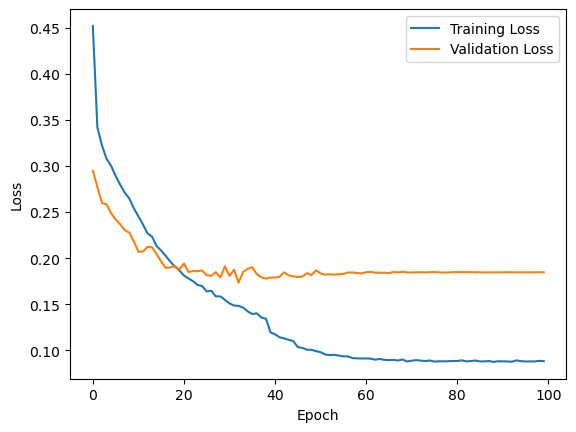

In [10]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_train_loss = 0
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = criterion(preds, y)
            epoch_val_loss += loss.item()
    
    # Calculate metrics
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(test_loader)
    scheduler.step(avg_val_loss)
    
    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        print('-'*50)

# Plot learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

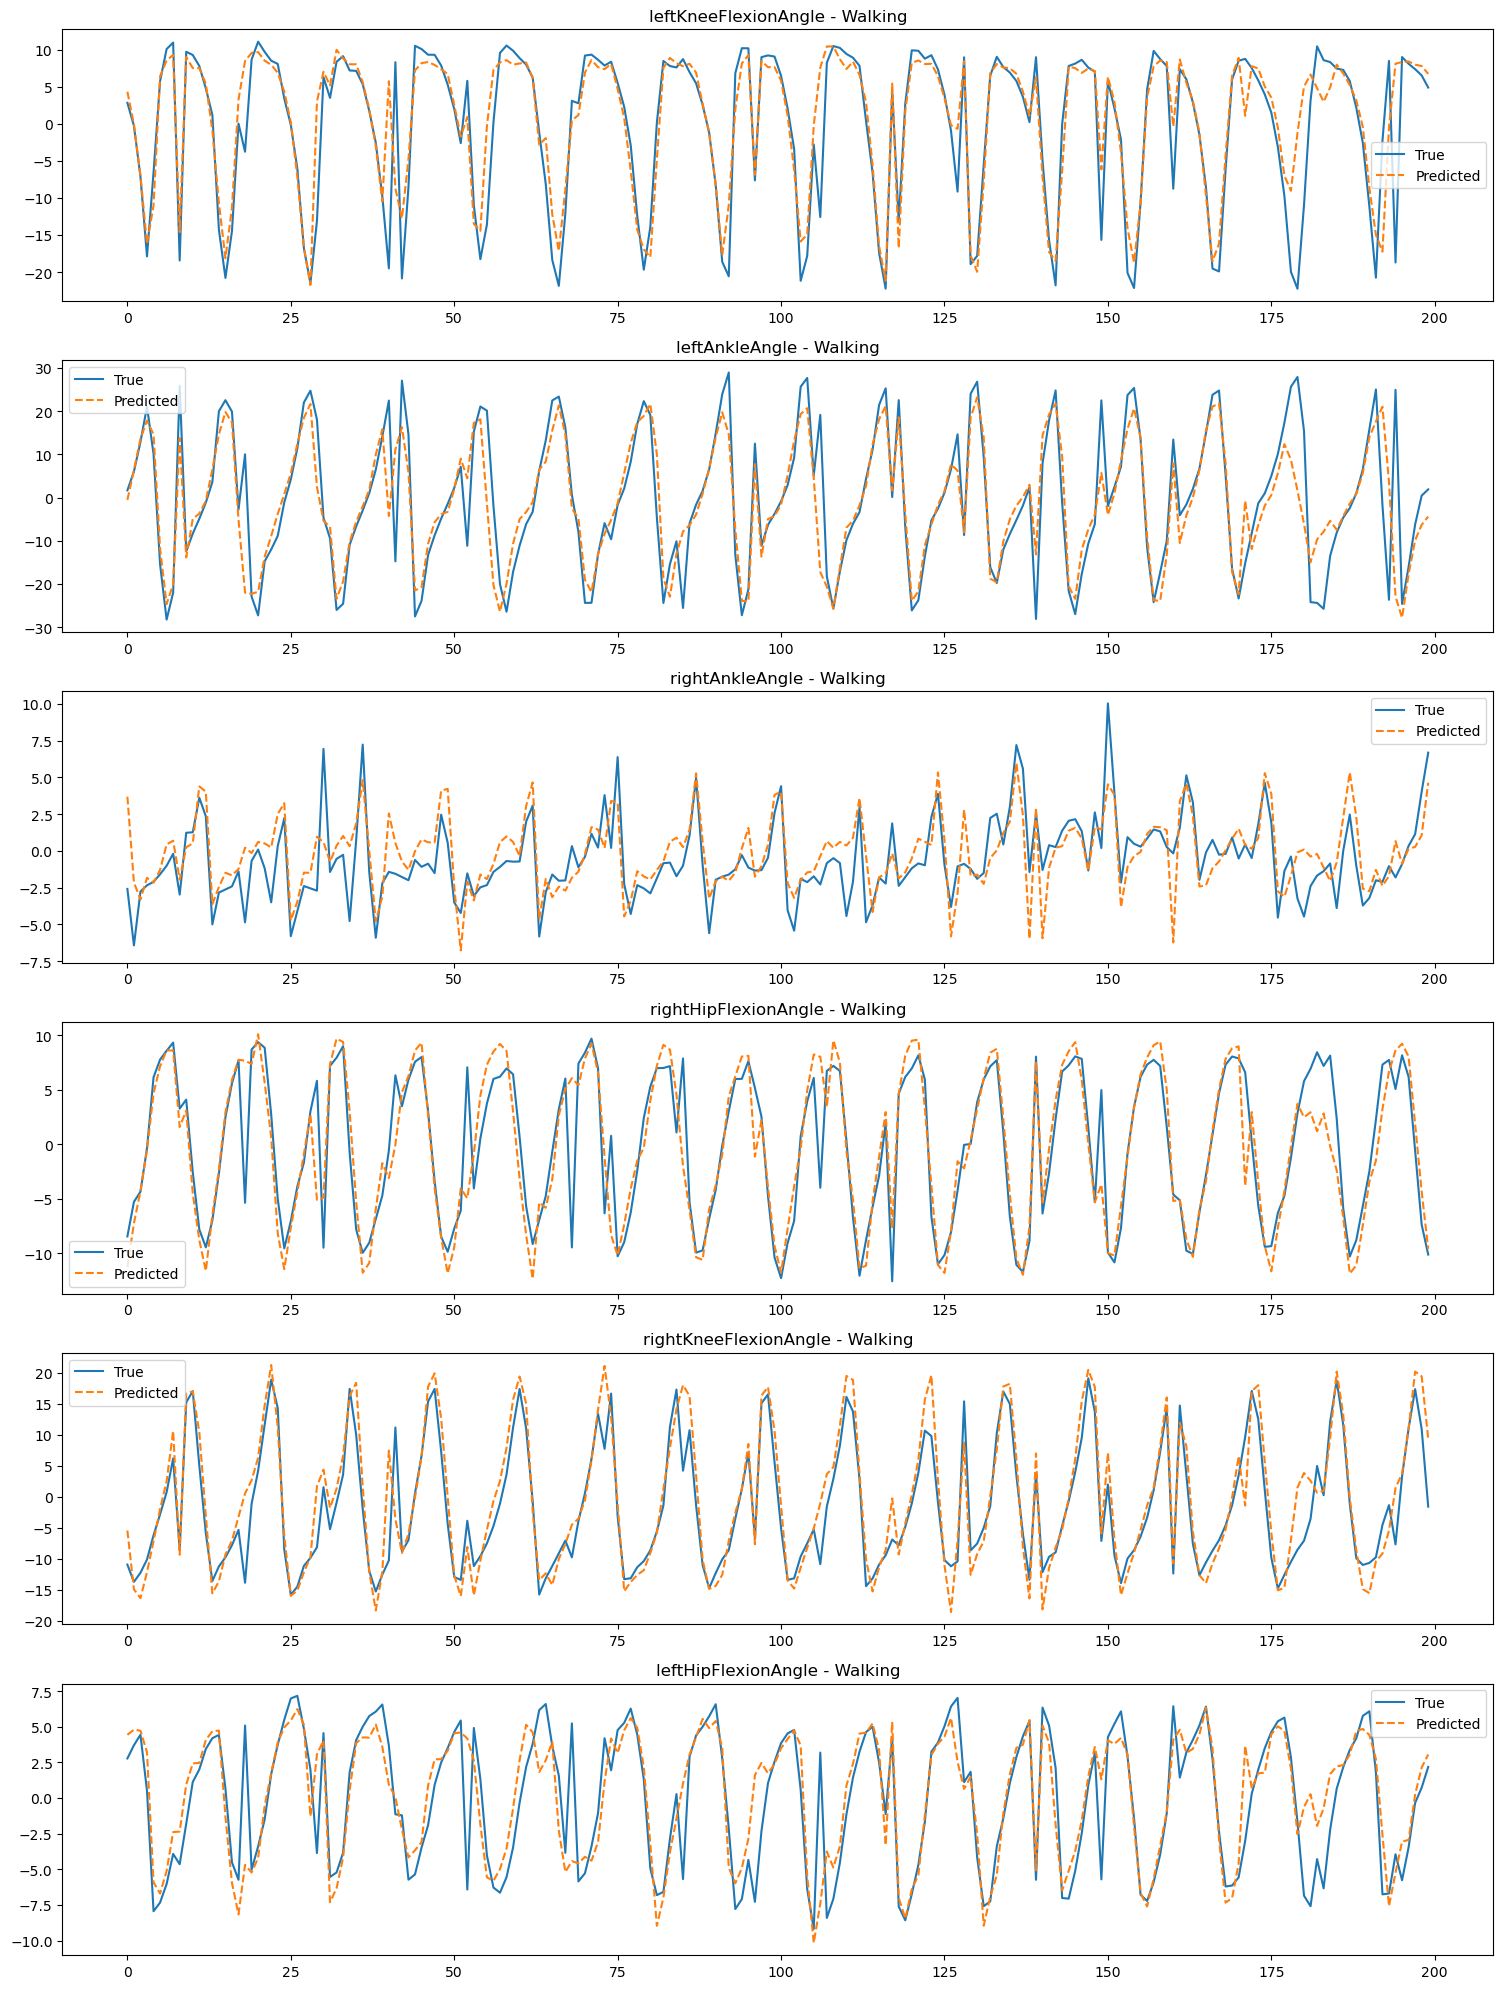

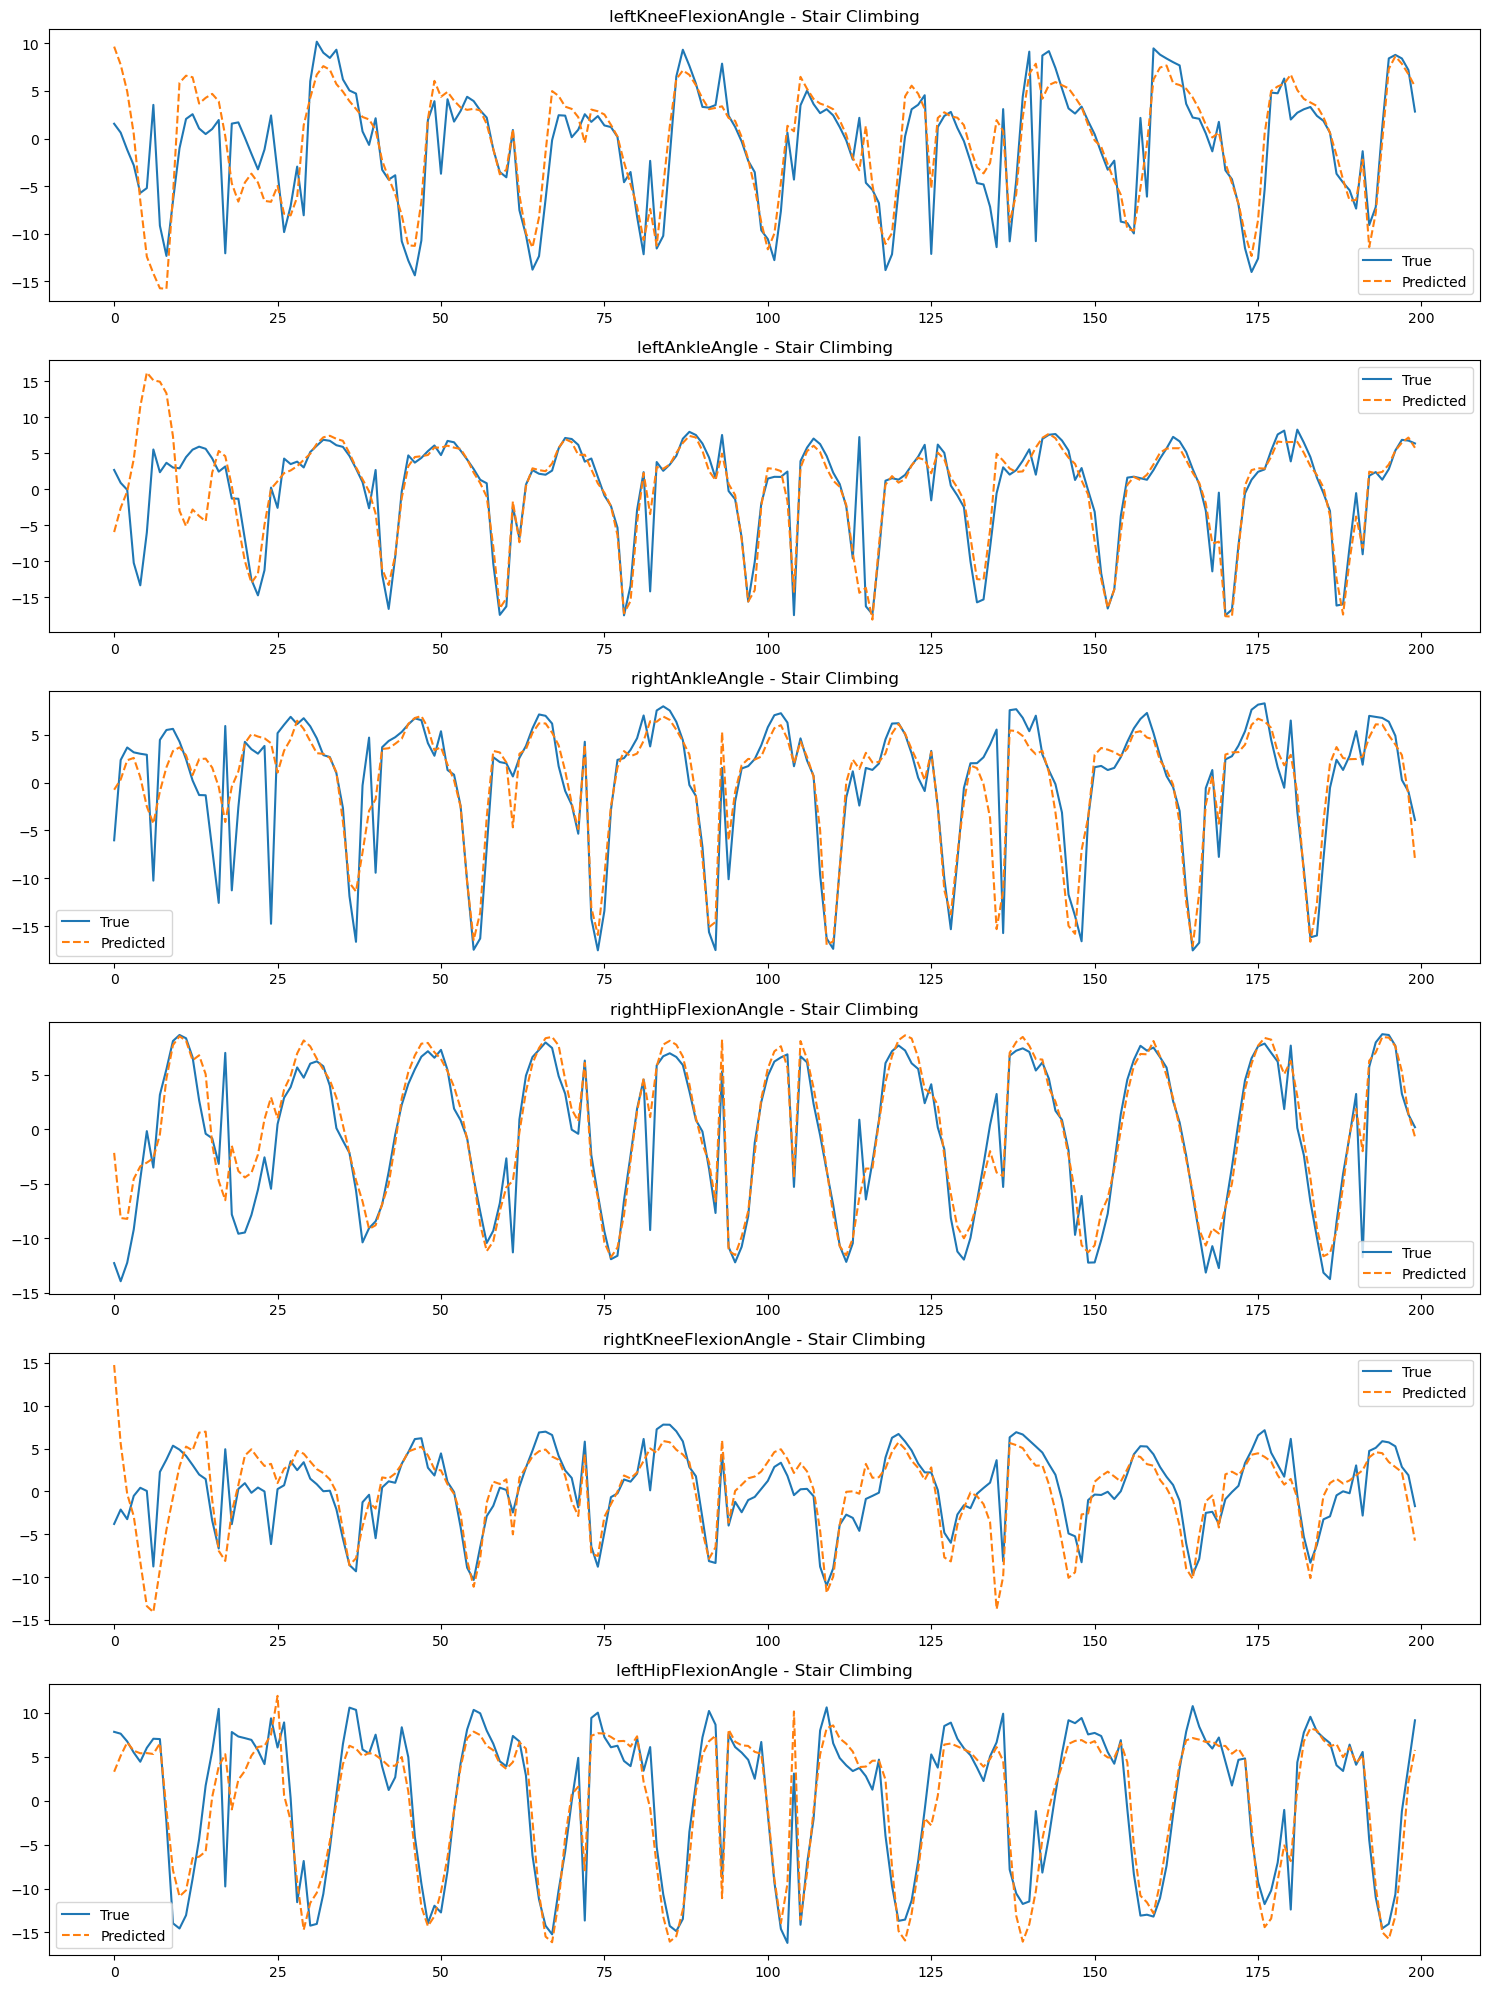

In [11]:
model.eval()
predictions = []
true_values = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        pred = model(X).cpu().numpy()
        predictions.append(pred)
        true_values.append(y.numpy())

predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)

# Unnormalize data
angle_predictions = scaler.inverse_transform(
    np.hstack([predictions, np.zeros((predictions.shape[0], 1))])[:, :-1]
)
angle_true_values = scaler.inverse_transform(
    np.hstack([true_values, np.zeros((true_values.shape[0], 1))])[:, :-1]
)

test_gaits = test_normalized[SEQ_LENGTH:, -1]
for gait_type in [0, 1]:
    gait_name = "Walking" if gait_type == 0 else "Stair Climbing"
    mask = test_gaits == gait_type
    if np.any(mask):  
        plt.figure(figsize=(15, 20))
        for i, col in enumerate(train_angles.columns):
            plt.subplot(6, 1, i+1)
            plt.plot(angle_true_values[mask][:200, i], label='True')
            plt.plot(angle_predictions[mask][:200, i], label='Predicted', linestyle='--')
            plt.title(f"{col} - {gait_name}")
            plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"No samples found for gait type: {gait_name}")

In [12]:
for tolerance in (10,5):
    # Check if each prediction is within the tolerance of the true value
    correct = np.abs(angle_predictions - angle_true_values) <= tolerance
    accuracy = np.mean(correct) * 100  

    print(f"Accuracy within ±{tolerance}°: {accuracy:.2f}%")

for gait_type in [0, 1]:
    gait_name = "Walking" if gait_type == 0 else "Stair Climbing"
    mask = test_normalized[SEQ_LENGTH:, -1] == gait_type
    
    for tolerance in (10, 5):
        correct = np.abs(angle_predictions[mask] - angle_true_values[mask]) <= tolerance
        accuracy = np.mean(correct) * 100
        print(f"{gait_name} Accuracy within ±{tolerance}°: {accuracy:.2f}%")

Accuracy within ±10°: 97.06%
Accuracy within ±5°: 87.91%
Walking Accuracy within ±10°: 94.94%
Walking Accuracy within ±5°: 81.85%
Stair Climbing Accuracy within ±10°: 97.70%
Stair Climbing Accuracy within ±5°: 89.75%


In [41]:
torch.save(model.state_dict(), "combinedModel.pt")